In [155]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

from tensorflow.keras.models import Sequential
#from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD, RMSprop

from tensorflow.keras.callbacks import EarlyStopping

# To gbm light
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB

from statistics import stdev


# dataset creation


In [2]:
calm_path = "2019_stress_detection_dataset\\CALM\\"
stress_path = "2019_stress_detection_dataset\\STRESS\\"

In [3]:
# reading calm files
calm_df = pd.DataFrame()

for i in range(1,111):
    for j in range(1, 8):
        file_path = calm_path + f"CALM_{i}_{j}.csv"
        try:
            #if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=";",header=None)
            calm_df = pd.concat([calm_df, df], axis=0)
            #else:
            #    print(f"File {file_path} does not exist.")
        except FileNotFoundError:
            print(f"File {file_path} not found.")

File 2019_stress_detection_dataset\CALM\CALM_1_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_1_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_2_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_2_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_3_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_3_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_4_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_4_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_5_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_5_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_6_5.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_6_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_6_7.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_7_6.csv not found.
File 2019_stress_detection_dataset\CALM\CALM_7_7.csv not found.
File 2019_stress_detection_dataset\CALM\

In [4]:
stress_df = pd.DataFrame()

for i in range(1,111):
    for j in range(1, 8):
        file_path = stress_path + f"STRESS_{i}_{j}.csv"
        try:
            #if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=";",header=None)
            stress_df = pd.concat([stress_df, df], axis=0)
            #else:
            #    print(f"File {file_path} does not exist.")
        except FileNotFoundError:
            print(f"File {file_path} not found.")


File 2019_stress_detection_dataset\STRESS\STRESS_1_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_1_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_2_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_2_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_3_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_3_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_4_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_4_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_5_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_5_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_6_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_6_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_7_6.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS_7_7.csv not found.
File 2019_stress_detection_dataset\STRESS\STRESS

In [52]:
calm_df1 = calm_df.iloc[:,:]
stress_df1 = stress_df.iloc[:,:]

In [53]:

# dropping columns not needed

calm_df1.drop([0, 5, 45, 46, 44], axis = 1, inplace = True)
stress_df1.drop([0, 5, 45, 46, 44], axis = 1, inplace = True)


In [62]:
print("calm:", calm_df1.shape)
print("stress:", stress_df1.shape)

calm: (704399, 42)
stress: (835973, 42)


In [56]:
# combining rows to reduce the rows
# combining 100 rows so 5 secs worth data in a single row

row_count = 100  # Change this value to control how many rows to stack horizontally

# Calculate the number of rows to add
num_rows_to_add = row_count - (len(calm_df1) % row_count)

# Generate NaN values for the new rows
new_rows_data = pd.DataFrame({col: [np.nan] * num_rows_to_add for col in calm_df1.columns})

# Append the new rows to the DataFrame
# padding NaN
# this is to make the rows in the dataframe a multiple of the row_count
calm_combine_df = pd.concat([calm_df1, new_rows_data], ignore_index=True)

n = len(calm_combine_df)
# Calculate the number of resulting columns
num_columns = calm_combine_df.shape[1] * row_count

# Reshape the DataFrame into desired shape
reshaped_values = np.reshape(calm_combine_df.values, (-1, row_count, calm_combine_df.shape[1]))
column_names = [f'{col}_{i}' for i in range(row_count) for col in calm_combine_df.columns]
calm_combine_df = pd.DataFrame(reshaped_values.reshape(-1, num_columns), columns=column_names)


In [57]:
# combining rows to reduce the rows
# combining 100 rows so 5 secs worth data in a single row

#row_count = 5  # Change this value to control how many rows to stack horizontally

# Calculate the number of rows to add
num_rows_to_add = row_count - (len(stress_df1) % row_count)

# Generate NaN values for the new rows
new_rows_data = pd.DataFrame({col: [np.nan] * num_rows_to_add for col in stress_df1.columns})

# Append the new rows to the DataFrame
# padding NaN
# this is to make the rows in the dataframe a multiple of the row_count
stress_combine_df = pd.concat([stress_df1, new_rows_data], ignore_index=True)

n = len(stress_combine_df)
# Calculate the number of resulting columns
num_columns = stress_combine_df.shape[1] * row_count

# Reshape the DataFrame into desired shape
reshaped_values = np.reshape(stress_combine_df.values, (-1, row_count, stress_combine_df.shape[1]))
column_names = [f'{col}_{i}' for i in range(row_count) for col in stress_combine_df.columns]
stress_combine_df = pd.DataFrame(reshaped_values.reshape(-1, num_columns), columns=column_names)


In [64]:
# target column
stress_combine_df['target']='S'
calm_combine_df['target']='C'


In [65]:
print("stress:", stress_combine_df.shape)
print("calm", calm_combine_df.shape)

stress: (8360, 4201)
calm (7044, 4201)


In [66]:

# combining the stress and the calm dataframes together
# ignoring the index and creating a new indexing

combined_df = pd.concat([stress_combine_df, calm_combine_df], axis = 0, ignore_index = True)


In [3]:
# combined_df = pd.read_csv("stress_calm_combined_dataset.csv")

In [8]:
# combined_df.drop(columns = ["43"],inplace = True)

In [ ]:
#combined_df1 = pd.DataFrame()
#for col in combined_df.columns:
#    combined_df1[col] = combined_df[col].astype(float)

In [118]:

# remove null value rows
#combined_df.dropna(inplace = True, axis = 0)

print("Null value count:", combined_df.isnull().sum().sum(), "\n\n")
print(combined_df.info())

Null value count: 0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15402 entries, 0 to 15401
Columns: 4201 entries, 1_0 to target
dtypes: float64(4100), int64(100), object(1)
memory usage: 493.7+ MB
None


In [108]:
# combined dataset
display(combined_df)

,1_0,2_0,3_0,4_0,6_0,7_0,8_0,9_0,10_0,11_0,...,35_99,36_99,37_99,38_99,39_99,40_99,41_99,42_99,43_99,target
0,30.0,1.0,1.0,0.0,27.0,-0.505169,4.584610,8.654279,9.806650,-0.505169,...,-0.286381,0.925547,0.174533,1.015117,33.013030,-28.199623,-5.462337,43.759754,14.0,1.0
1,30.0,1.0,6.0,0.0,27.0,-0.855542,4.732930,8.483661,9.752183,-0.933509,...,-0.323044,0.909478,0.174533,1.015117,39.167664,-30.342365,0.213621,49.546043,14.0,1.0
2,30.0,1.0,10.0,0.0,27.0,-0.047479,4.653396,7.789553,9.073780,0.036563,...,-0.319533,0.913167,0.174533,1.015117,38.223083,-29.286270,-1.333966,48.171250,14.0,1.0
3,30.0,1.0,15.0,0.0,27.0,-0.391895,4.711204,8.981483,10.149683,-0.228299,...,-0.295406,0.915288,0.174533,1.015117,34.622253,-31.549316,-4.077767,47.017956,14.0,1.0
4,30.0,1.0,21.0,0.0,27.0,-0.634820,5.042921,8.471726,9.879483,-0.697355,...,-0.304992,0.918151,0.174533,1.015117,35.866670,-29.122353,-3.403648,46.326168,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15398,21.0,1.0,45.0,6.0,71.0,0.543500,6.359194,7.546754,9.883736,0.391518,...,0.748220,0.563671,0.000000,0.999999,252.835270,-40.727386,4.840062,256.140230,0.0,0.0
15399,21.0,1.0,52.0,6.0,71.0,0.459701,6.213143,8.200391,10.298587,0.627046,...,0.745329,0.544084,0.000000,0.999999,252.074680,-45.319305,0.774670,256.117300,0.0,0.0
15400,21.0,1.0,58.0,6.0,71.0,-0.347170,6.900300,7.733508,10.370237,0.093229,...,0.743197,0.562262,0.000000,0.999999,253.108890,-42.319200,4.657597,256.664600,0.0,0.0
15401,21.0,1.0,68.0,6.0,71.0,0.543500,6.385531,6.677632,9.255332,0.588795,...,0.757537,0.550680,0.000000,0.999999,251.594000,-41.008400,1.832259,254.920730,0.0,0.0


In [72]:
# Encode the 'gender' column using LabelEncoder
enc = LabelEncoder()

# Assuming `combined_df` is your DataFrame containing columns from gender_0 to gender_99
for i in range(100):  # Assuming you have 100 columns from gender_0 to gender_99
    column_name = f'2_{i}'  # Construct the column name
    if column_name in combined_df.columns:
        combined_df[column_name] = enc.fit_transform(combined_df[column_name])

# Check the DataFrame after label encoding
display(combined_df.head())

,1_0,2_0,3_0,4_0,6_0,7_0,8_0,9_0,10_0,11_0,...,35_99,36_99,37_99,38_99,39_99,40_99,41_99,42_99,43_99,target
0,30.0,1,1.0,0.0,27.0,-0.505169,4.58461,8.654279,9.80665,-0.505169,...,-0.286381,0.925547,0.174533,1.015117,33.01303,-28.199623,-5.462337,43.759754,14.0,S
1,30.0,1,6.0,0.0,27.0,-0.855542,4.73293,8.483661,9.752183,-0.933509,...,-0.323044,0.909478,0.174533,1.015117,39.167664,-30.342365,0.213621,49.546043,14.0,S
2,30.0,1,10.0,0.0,27.0,-0.047479,4.653396,7.789553,9.07378,0.036563,...,-0.319533,0.913167,0.174533,1.015117,38.223083,-29.28627,-1.333966,48.17125,14.0,S
3,30.0,1,15.0,0.0,27.0,-0.391895,4.711204,8.981483,10.149683,-0.228299,...,-0.295406,0.915288,0.174533,1.015117,34.622253,-31.549316,-4.077767,47.017956,14.0,S
4,30.0,1,21.0,0.0,27.0,-0.63482,5.042921,8.471726,9.879483,-0.697355,...,-0.304992,0.918151,0.174533,1.015117,35.86667,-29.122353,-3.403648,46.326168,14.0,S


In [73]:
# Print the mapping between original categorical values and numerical labels
print("Mapping of original values to numerical labels:")
for original_value, numerical_label in zip(enc.classes_, enc.transform(enc.classes_)):
    print(f"{original_value}: {numerical_label}")

Mapping of original values to numerical labels:
Female: 0
Male: 1


In [120]:
print("combined_df:", combined_df.shape)

display(combined_df)

combined_df: (15402, 4201)


,1_0,2_0,3_0,4_0,6_0,7_0,8_0,9_0,10_0,11_0,...,35_99,36_99,37_99,38_99,39_99,40_99,41_99,42_99,43_99,target
0,30.0,1,1.0,0.0,27.0,-0.505169,4.584610,8.654279,9.806650,-0.505169,...,-0.286381,0.925547,0.174533,1.015117,33.013030,-28.199623,-5.462337,43.759754,14.0,1
1,30.0,1,6.0,0.0,27.0,-0.855542,4.732930,8.483661,9.752183,-0.933509,...,-0.323044,0.909478,0.174533,1.015117,39.167664,-30.342365,0.213621,49.546043,14.0,1
2,30.0,1,10.0,0.0,27.0,-0.047479,4.653396,7.789553,9.073780,0.036563,...,-0.319533,0.913167,0.174533,1.015117,38.223083,-29.286270,-1.333966,48.171250,14.0,1
3,30.0,1,15.0,0.0,27.0,-0.391895,4.711204,8.981483,10.149683,-0.228299,...,-0.295406,0.915288,0.174533,1.015117,34.622253,-31.549316,-4.077767,47.017956,14.0,1
4,30.0,1,21.0,0.0,27.0,-0.634820,5.042921,8.471726,9.879483,-0.697355,...,-0.304992,0.918151,0.174533,1.015117,35.866670,-29.122353,-3.403648,46.326168,14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15397,21.0,1,45.0,6.0,71.0,0.543500,6.359194,7.546754,9.883736,0.391518,...,0.748220,0.563671,0.000000,0.999999,252.835270,-40.727386,4.840062,256.140230,0.0,0
15398,21.0,1,52.0,6.0,71.0,0.459701,6.213143,8.200391,10.298587,0.627046,...,0.745329,0.544084,0.000000,0.999999,252.074680,-45.319305,0.774670,256.117300,0.0,0
15399,21.0,1,58.0,6.0,71.0,-0.347170,6.900300,7.733508,10.370237,0.093229,...,0.743197,0.562262,0.000000,0.999999,253.108890,-42.319200,4.657597,256.664600,0.0,0
15400,21.0,1,68.0,6.0,71.0,0.543500,6.385531,6.677632,9.255332,0.588795,...,0.757537,0.550680,0.000000,0.999999,251.594000,-41.008400,1.832259,254.920730,0.0,0


In [89]:
# checking balanced target

print("target count ratio:")
print(combined_df["target"].value_counts()/len(combined_df))


target count ratio:
target
S    0.542722
C    0.457278
Name: count, dtype: float64


In [95]:
# saving created dataset to csv file
combined_df.to_csv('combined_dataset_5sec.csv', index=False)

In [116]:
# loading csv file
combined_df = pd.read_csv("combined_dataset_5sec.csv")

# EDA

In [ ]:
palette = ["#ADD8E6","#EFB000"]

# ML models

In [149]:
X = combined_df.drop('target', axis = 1)
y = combined_df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

Accuracy: 0.9600778967867576

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1403
           1       0.97      0.96      0.96      1678

    accuracy                           0.96      3081
   macro avg       0.96      0.96      0.96      3081
weighted avg       0.96      0.96      0.96      3081

Confusion Matrix:


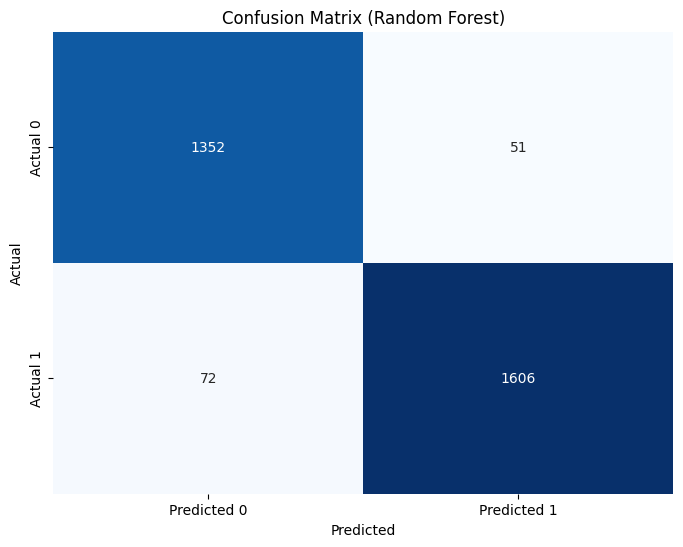

In [138]:
# Random Forest


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=50)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test data
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the model
rf_accuracy = (rf_predictions == y_test).mean()
print("Accuracy:", rf_accuracy)


# Generate classification report
rf_class_report = classification_report(y_test, rf_predictions)
print("\nClassification Report (Random Forest):")
print(rf_class_report)

# Generate confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:")
#print(rf_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


In [135]:
# 10 fold using randomforest
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier 


# Initialize the classifier
clf = RandomForestClassifier(n_estimators=300, max_depth=50) 

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", cv_scores.mean())


Cross-Validation Scores: [0.96430889 0.96950032 0.97337662 0.96558442 0.95909091 0.96948052
 0.97012987 0.96428571 0.96038961 0.97792208]
Average Cross-Validation Score: 0.9674068955055326


EValuation of Random Forest: 
Precision: 0.9692214846107423
Recall (Sensitivity): 0.9570917759237187
F1-score: 0.9631184407796102
ROC AUC: 0.995511915977766
Average Precision: 0.9962850217189884
Log Loss: 0.17437863420971414
Matthews Correlation Coefficient: 0.9196998040142417
Cohen's Kappa: 0.9196131807376073


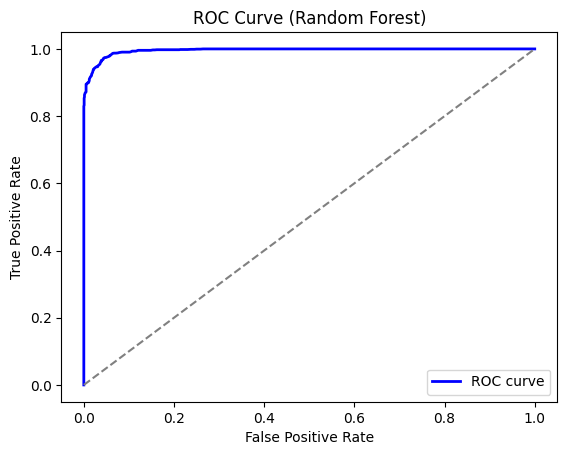

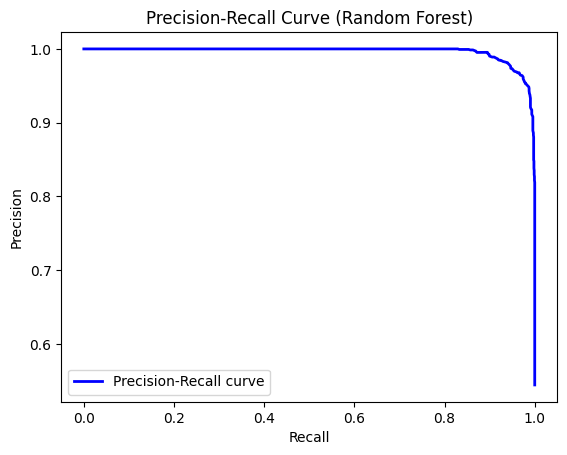

In [167]:
# evaluation
print("EValuation of Random Forest: ")


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, log_loss, matthews_corrcoef, cohen_kappa_score
#from sklearn.metrics import precision_recall_curve, roc_curve, plot_precision_recall_curve, plot_roc_curve

# Calculate Precision
precision = precision_score(y_test, rf_predictions)

# Calculate Recall (Sensitivity)
recall = recall_score(y_test, rf_predictions)

# Calculate F1-score
f1 = f1_score(y_test, rf_predictions)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:,1])

# Calculate Average Precision
average_precision = average_precision_score(y_test, rf_classifier.predict_proba(X_test)[:,1])

# Calculate Log Loss
logloss = log_loss(y_test, rf_classifier.predict_proba(X_test))

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, rf_predictions)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, rf_predictions)

# Print the calculated metrics
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)
print("Average Precision:", average_precision)
print("Log Loss:", logloss)
print("Matthews Correlation Coefficient:", mcc)
print("Cohen's Kappa:", kappa)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_classifier.predict_proba(X_test)[:,1])
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend(loc='lower left')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


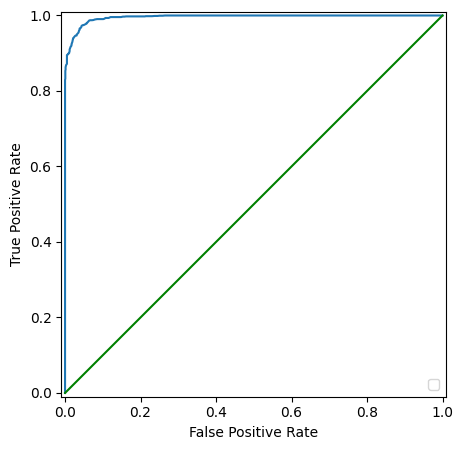

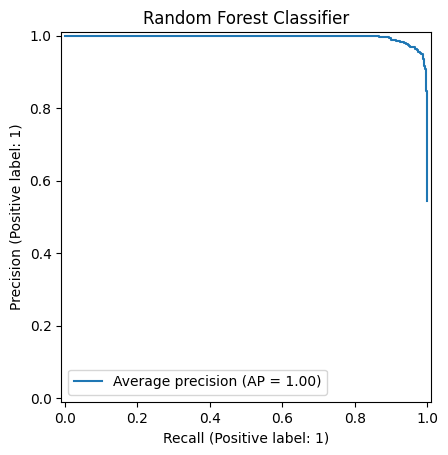

In [170]:

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(5,5)
plt.plot([0, 1], [0, 1], color = 'g')
    



from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    rf_classifier, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest Classifier")

In [ ]:
# # GNB gaussian


# # Create a Gaussian Naive Bayes classifier
# gnb_classifier = GaussianNB()

# # Train the classifier on the training data
# gnb_classifier.fit(X_train, y_train)

# # Predict on the test data
# gnb_predictions = gnb_classifier.predict(X_test)

# # Generate confusion matrix
# gnb_conf_matrix = confusion_matrix(y_test, gnb_predictions)
# print("Confusion Matrix:")
# #print(gnb_conf_matrix)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(gnb_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["Predicted 0", "Predicted 1"], 
#             yticklabels=["Actual 0", "Actual 1"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix (Gaussian Naive Bayes)")
# plt.show()

# # Generate classification report
# gnb_class_report = classification_report(y_test, gnb_predictions)
# print("\nClassification Report (Gaussian Naive Bayes):")
# print(gnb_class_report)

In [ ]:
# # logistic regression

# from sklearn.linear_model import LogisticRegression

# # Create a Logistic Regression classifier
# log_reg_classifier = LogisticRegression()

# # Train the classifier on the training data
# log_reg_classifier.fit(X_train, y_train)

# # Predict on the test data
# log_reg_predictions = log_reg_classifier.predict(X_test)

# # Generate confusion matrix
# log_reg_conf_matrix = confusion_matrix(y_test, log_reg_predictions)
# print("Confusion Matrix:")
# #print(log_reg_conf_matrix)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(log_reg_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
#             xticklabels=["Predicted 0", "Predicted 1"], 
#             yticklabels=["Actual 0", "Actual 1"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix (Logistic Regression)")
# plt.show()


# # Generate classification report
# log_reg_class_report = classification_report(y_test, log_reg_predictions)
# print("\nClassification Report (Logistic Regression):")
# print(log_reg_class_report)

In [119]:
# # encoding target to numerical
# enc_target = LabelEncoder()

# # Assuming `combined_df` is your DataFrame containing columns from target
# column_name = "target"
# combined_df[column_name] = enc_target.fit_transform(combined_df[column_name])

# # Print the mapping between original categorical values and numerical labels
# print("Mapping of original values to numerical labels:")
# for original_value, numerical_label in zip(enc_target.classes_, enc_target.transform(enc_target.classes_)):
#     print(f"{original_value}: {numerical_label}")

Mapping of original values to numerical labels:
C: 0
S: 1


[LightGBM] [Info] Number of positive: 6681, number of negative: 5640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.342833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869617
[LightGBM] [Info] Number of data points in the train set: 12321, number of used features: 4200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542245 -> initscore=0.169384
[LightGBM] [Info] Start training from score 0.169384
Validation Accuracy: 0.9746835443037974
Confusion Matrix:


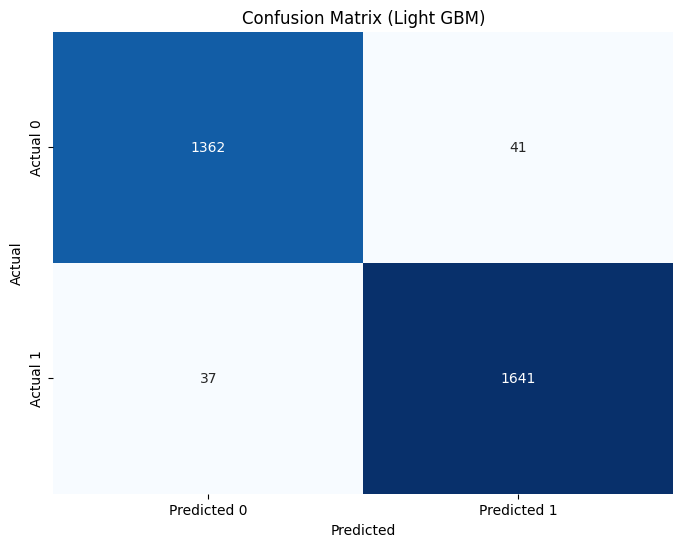

Classification Report (Light GBM):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1403
           1       0.98      0.98      0.98      1678

    accuracy                           0.97      3081
   macro avg       0.97      0.97      0.97      3081
weighted avg       0.97      0.97      0.97      3081



In [141]:

lgbm = LGBMClassifier(n_estimators=500, random_state=42)

lgbm.fit(X_train, y_train)

# Make predictions
lgbm_y_test_pred = lgbm.predict(X_test)

# Evaluate the model
lgbm_accuracy = accuracy_score(y_test, lgbm_y_test_pred)
print("Validation Accuracy:", lgbm_accuracy)

# Confusion Matrix
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_y_test_pred)
print("Confusion Matrix:")
#print(lgbm_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lgbm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Light GBM)")
plt.show()


# Classification Report
lgbm_class_report = classification_report(y_test, lgbm_y_test_pred)
print("Classification Report (Light GBM):")
print(lgbm_class_report)

In [ ]:
# 10 fold using randomforest
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier # You can replace this with any other classifier you want to use


# Initialize the classifier
clf = RandomForestClassifier(n_estimators=300, max_depth=50) # You can replace this with any other classifier you want to use

# Initialize KFold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", cv_scores.mean())


c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7870821161960403
Confusion Matrix:


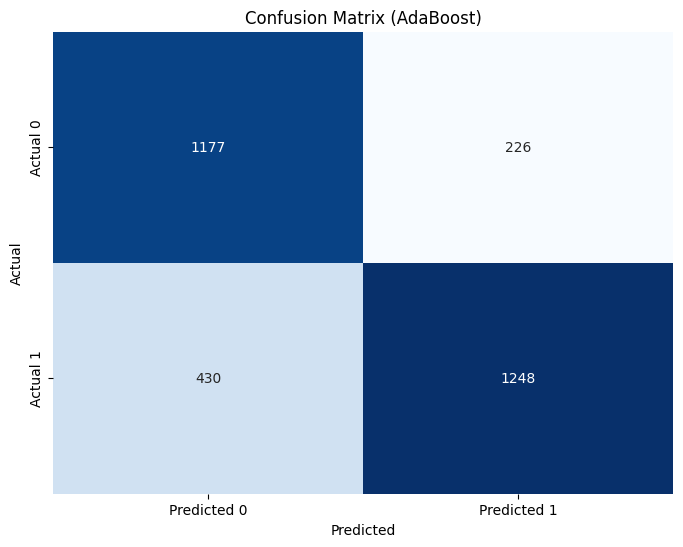

Classification Report (AdaBoost):
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1403
           1       0.85      0.74      0.79      1678

    accuracy                           0.79      3081
   macro avg       0.79      0.79      0.79      3081
weighted avg       0.79      0.79      0.79      3081



In [142]:
# adaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


# Initialize AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the classifier
adaboost_clf.fit(X_train, y_train)

# Predict on the test set
adaboost_y_pred = adaboost_clf.predict(X_test)

# Calculate accuracy
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
print("Accuracy:", adaboost_accuracy)

# Assuming you've already trained the AdaBoostClassifier and made predictions
# adaboost_clf.fit(X_train, y_train)
# y_pred = adaboost_clf.predict(X_test)

# Confusion Matrix
adaboost_conf_matrix = confusion_matrix(y_test, adaboost_y_pred)
print("Confusion Matrix:")
# print(adaboost_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (AdaBoost)")
plt.show()

# Classification Report
adaboost_class_report = classification_report(y_test, adaboost_y_pred)
print("Classification Report (AdaBoost):")
print(adaboost_class_report)



Accuracy: 0.9620253164556962
Confusion Matrix:


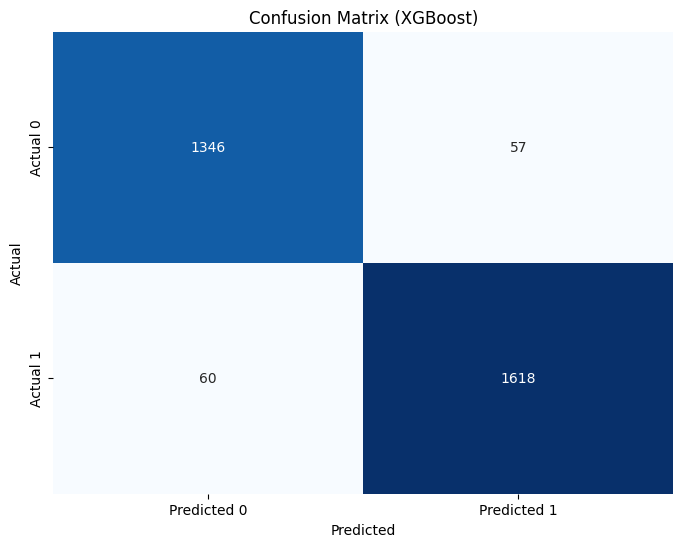

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1403
           1       0.97      0.96      0.97      1678

    accuracy                           0.96      3081
   macro avg       0.96      0.96      0.96      3081
weighted avg       0.96      0.96      0.96      3081



In [143]:
# XGBoost

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the classifier
xgb_clf.fit(X_train, y_train)

# Predict on the test set
xgb_y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print("Accuracy:", xgb_accuracy)

# Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)
print("Confusion Matrix:")
# print(xgb_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

# Classification Report
xgb_class_report = classification_report(y_test, xgb_y_pred)
print("Classification Report (XGBoost):")
print(xgb_class_report)

Accuracy: 0.9769555339175592

Confusion Matrix:


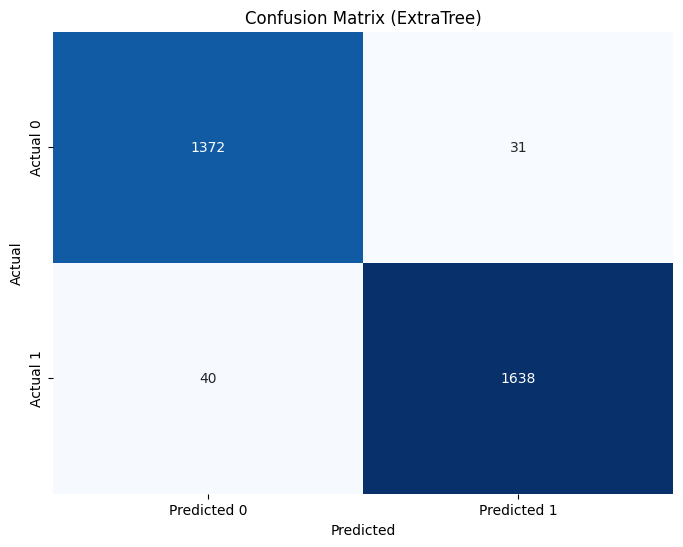


Classification Report (ExtraTree):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1403
           1       0.98      0.98      0.98      1678

    accuracy                           0.98      3081
   macro avg       0.98      0.98      0.98      3081
weighted avg       0.98      0.98      0.98      3081



In [144]:
# extra tree

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# Assuming you have already loaded and split your data into X_train, X_test, y_train, y_test

# Initialize ExtraTreesClassifier
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Train the classifier
extra_trees_clf.fit(X_train, y_train)

# Predict on the test set
extra_trees_y_pred = extra_trees_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, extra_trees_y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
extra_trees_conf_matrix = confusion_matrix(y_test, extra_trees_y_pred)
print("\nConfusion Matrix:")
# print(extra_trees_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(extra_trees_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ExtraTree)")
plt.show()

# Classification Report
extra_trees_class_report = classification_report(y_test, extra_trees_y_pred)
print("\nClassification Report (ExtraTree):")
print(extra_trees_class_report)


[LightGBM] [Info] Number of positive: 6681, number of negative: 5640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.808701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869617
[LightGBM] [Info] Number of data points in the train set: 12321, number of used features: 4200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542245 -> initscore=0.169384
[LightGBM] [Info] Start training from score 0.169384


c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix:


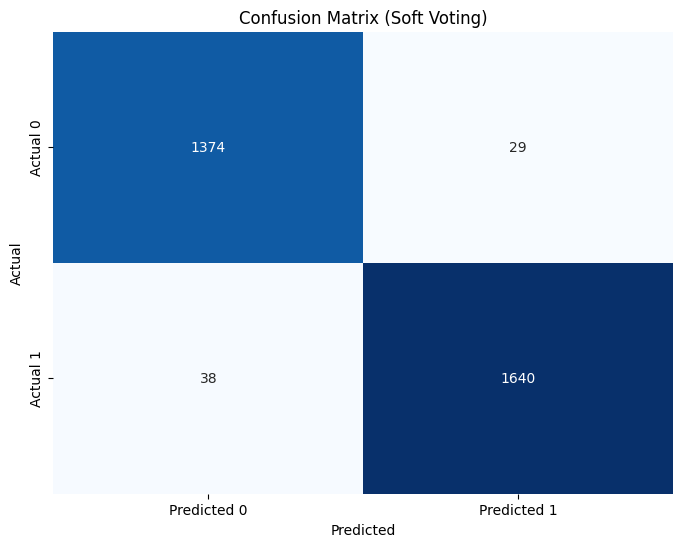


Classification Report (Soft Voting):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1403
           1       0.98      0.98      0.98      1678

    accuracy                           0.98      3081
   macro avg       0.98      0.98      0.98      3081
weighted avg       0.98      0.98      0.98      3081



In [157]:
# soft voting ensemble learning

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, classification_report


estimators = []

estimators.append(('rf', RandomForestClassifier(n_estimators=300, max_depth=50)))
#estimators.append(('gnb', GaussianNB() ))
#estimators.append(('lr', LogisticRegression(random_state=42) ))
estimators.append(('LGBM' , LGBMClassifier(n_estimators=500, random_state=42)))
estimators.append(('ada', AdaBoostClassifier(n_estimators=100, random_state=42) ))
estimators.append(('XGboost', xgb.XGBClassifier(objective='binary:logistic', random_state=42) ))
estimators.append(('extraTree', ExtraTreesClassifier(n_estimators=100, random_state=42) ))


# # Define the base classifiers
# gnb_classifier = GaussianNB()
# lr_classifier = LogisticRegression(random_state=42)
# #et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
# #lgbm = LGBMClassifier(n_estimators=500, random_state=42)
# adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)


# Create a Soft Voting Classifier
voting_classifier = VotingClassifier(estimators = estimators, voting='soft')

# Train the classifier on the training data
voting_classifier.fit(X_train, y_train)

# Predict on the test data
voting_predictions = voting_classifier.predict(X_test)

# Generate confusion matrix
voting_conf_matrix = confusion_matrix(y_test, voting_predictions)
print("Confusion Matrix:")
# print(voting_conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(voting_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Soft Voting)")
plt.show()

# Generate classification report
voting_class_report = classification_report(y_test, voting_predictions)
print("\nClassification Report (Soft Voting):")
print(voting_class_report)


In [158]:
voting_class_Recall = recall_score(y_test, voting_predictions)
voting_class_Precision = precision_score(y_test, voting_predictions)
voting_class_f1 = f1_score(y_test, voting_predictions)
voting_class_accuracy = accuracy_score(y_test, voting_predictions)

In [159]:
# 10 fold using randomforest
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier # You can replace this with any other classifier you want to use


# Initialize KFold with 10 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(voting_classifier, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", cv_scores.mean())


[LightGBM] [Info] Number of positive: 6681, number of negative: 5640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.860095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 869617
[LightGBM] [Info] Number of data points in the train set: 12321, number of used features: 4200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542245 -> initscore=0.169384
[LightGBM] [Info] Start training from score 0.169384


c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
VC_soft_cv_score = cv_scores.mean()
VC_soft_cv_stdev = stdev(cv_scores)

voting_class_results = [(voting_class_Recall, voting_class_Precision, voting_class_f1, voting_class_accuracy, VC_soft_cv_score, VC_soft_cv_stdev)]


voting_class_score = pd.DataFrame(data = voting_class_results, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg Soft Voting Acuracy', 'Standard Deviation of Soft Voting Accuracy'])
voting_class_score.insert(0, 'Voting Classifier', 'Soft Voting')
display(voting_class_score)

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg Soft Voting Acuracy,Standard Deviation of Soft Voting Accuracy
0,Soft Voting,0.464243,0.744742,0.571953,0.621551,0.967407,0.005806


In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, voting_predictions)
print(f"AUC-ROC Curve for Voting Classifier with soft voting: {ROCAUCscore:.4f}")

In [ ]:
y_proba = voting_classifier.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])

# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    voting_classifier, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Voting Classifier with soft voting")

c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5498 - loss: 0.6959 - val_accuracy: 0.5514 - val_loss: 0.6860
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5474 - loss: 0.6874 - val_accuracy: 0.5521 - val_loss: 0.6860
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5451 - loss: 0.6871 - val_accuracy: 0.5475 - val_loss: 0.6864
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5489 - loss: 0.6864 - val_accuracy: 0.5479 - val_loss: 0.6865
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5412 - loss: 0.6877 - val_accuracy: 0.5475 - val_loss: 0.6863
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5471 - loss: 0.6859 - val_accuracy: 0.5482 - val_loss: 0.6863
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5428 - loss: 0.6871 - val_accuracy: 0.5482 - val_loss: 0.6867
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5446 - loss: 0.6878 - val_acc

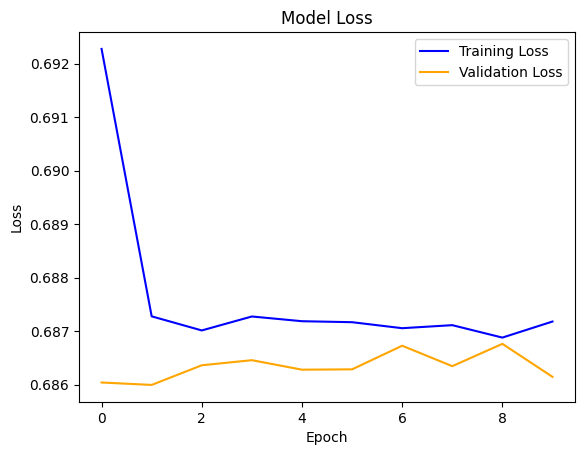

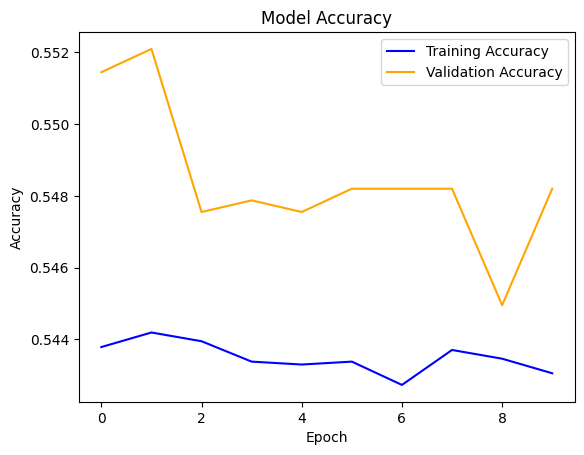

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5409 - loss: 0.6868
Loss: 0.6861464977264404
Accuracy: 0.5481986403465271


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [146]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# Reshape input data into 3D tensor (samples, timesteps, features)
timesteps = 1  # Each row represents a timestep
n_features = X_train.shape[1]  # Number of features
X_train_reshape = X_train.values.reshape((X_train.shape[0], timesteps, n_features))
X_test_reshape = X_test.values.reshape((X_test.shape[0], timesteps, n_features))

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
lstm_history = lstm_model.fit(X_train_reshape, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshape, y_test), verbose=1)

# Plot training and validation loss
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print('Loss:', lstm_loss)
print('Accuracy:', lstm_accuracy)

# Predict probabilities on test data
lstm_y_pred_prob = lstm_model.predict(X_test)

# Threshold probabilities to get predicted classes
lstm_y_pred = (lstm_y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
lstm_conf_matrix = confusion_matrix(y_test, lstm_y_pred)
print('Confusion Matrix:')
print(lstm_conf_matrix)

# Compute classification report
lstm_class_report = classification_report(y_test, lstm_y_pred)
print('Classification Report:')
print(lstm_class_report)


# Extra code

In [ ]:
# # Encode the 'gender' column using LabelEncoder
# enc = LabelEncoder()

# # Assuming `combined_df` is your DataFrame containing columns from gender_0 to gender_99
# for i in range(100):  # Assuming you have 100 columns from gender_0 to gender_99
#     column_name = f'gender_{i}'  # Construct the column name
#     if column_name in combined_df.columns:
#         combined_df[column_name] = enc.fit_transform(combined_df[column_name])

# # Check the DataFrame after label encoding
# display(combined_df.head())

,participant_id_0,age_0,gender_0,key_press_count_0,delete_key_press_count_0,text_id_0,text_length_0,accelerometer_x_0,accelerometer_y_0,accelerometer_z_0,...,rotation_sensor_z_99,rotation_sensor_scalar_99,rotation_sensor_value_99,rotation_sensor_magnitude_99,orientation_azimuth_99,orientation_pitch_99,orientation_roll_99,orientation_sensor_magnitude_99,number_of_steps_99,stress
0,48.0,19.0,1,1.0,0.0,2.0,47.0,-0.1632,2.1094,9.5301,...,0.873417,0.478776,0.0,0.999999,237.51999,-9.42,3.83,237.73756,19447.0,0
1,48.0,19.0,1,9.0,3.0,2.0,47.0,0.5255,1.7001,9.0246,...,0.877669,0.46584,0.0,0.999999,236.18,-12.49,2.99,236.52892,19447.0,0
2,48.0,19.0,1,16.0,5.0,2.0,47.0,0.9013,2.2281,9.7232,...,0.880441,0.460004,0.0,0.999999,235.54999,-12.84,3.01,235.91888,19447.0,0
3,48.0,19.0,1,22.0,5.0,2.0,47.0,0.396,2.1716,9.5331,...,0.878422,0.465471,0.0,1.0,235.98999,-12.28,2.13,236.31888,19447.0,0
4,48.0,19.0,1,30.0,5.0,2.0,47.0,0.3489,2.0231,9.649099,...,0.881136,0.455288,0.0,1.0,235.0,-14.219999,3.54,235.45645,19447.0,0


In [ ]:
# # Print the mapping between original categorical values and numerical labels
# print("Mapping of original values to numerical labels:")
# for original_value, numerical_label in zip(enc.classes_, enc.transform(enc.classes_)):
#     print(f"{original_value}: {numerical_label}")

Mapping of original values to numerical labels:
Female: 0
Male: 1


In [ ]:
# # dropping target col and participant_id(0-99)
# col_drop = ["stress"]
# col_drop.extend([f"participant_id_{i}" for i in range(100)])

# X = combined_df.drop(col_drop, axis = 1)
# y = combined_df["stress"]



In [ ]:
# # pca
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

In [ ]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
# print(combined_df["stress"].value_counts())

stress
0    865
1    865
Name: count, dtype: int64


In [ ]:
# split_shape = {"TRAINING": [X_train.shape,y_train.shape],
# #               "VALIDATING": [X_val.shape, y_val.shape],
#                "TESTING": [X_test.shape, y_test.shape]}

# split_shape_df = pd.DataFrame(split_shape, index=["X shape", "y shape"])
# display(split_shape_df)


,TRAINING,TESTING
X shape,"(1384, 1000)","(346, 1000)"
y shape,"(1384,)","(346,)"


In [ ]:
# # Random Forest

# # Create a Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier on the training data
# rf_classifier.fit(X_train, y_train)

# # Predict on the test data
# predictions = rf_classifier.predict(X_test)

# # Evaluate the model
# accuracy = (predictions == y_test).mean()
# print("Accuracy:", accuracy)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate classification report
# class_report = classification_report(y_test, predictions)
# print("\nClassification Report:")
# print(class_report)

Accuracy: 0.10115606936416185
Confusion Matrix:
[[ 14 172]
 [139  21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.08      0.08       186
           1       0.11      0.13      0.12       160

    accuracy                           0.10       346
   macro avg       0.10      0.10      0.10       346
weighted avg       0.10      0.10      0.10       346



In [12]:
# # GNB gaussian

# from sklearn.naive_bayes import GaussianNB
# # Create a Gaussian Naive Bayes classifier
# gnb_classifier = GaussianNB()

# # Train the classifier on the training data
# gnb_classifier.fit(X_train, y_train)

# # Predict on the test data
# predictions = gnb_classifier.predict(X_test)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate classification report
# class_report = classification_report(y_test, predictions)
# print("\nClassification Report:")
# print(class_report)

Confusion Matrix:
[[102169  39043]
 [100272  66591]]

Classification Report:
              precision    recall  f1-score   support

           C       0.50      0.72      0.59    141212
           S       0.63      0.40      0.49    166863

    accuracy                           0.55    308075
   macro avg       0.57      0.56      0.54    308075
weighted avg       0.57      0.55      0.54    308075



In [13]:
# # logistic regression

# from sklearn.linear_model import LogisticRegression

# # Create a Logistic Regression classifier
# log_reg_classifier = LogisticRegression()

# # Train the classifier on the training data
# log_reg_classifier.fit(X_train, y_train)

# # Predict on the test data
# predictions = log_reg_classifier.predict(X_test)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate classification report
# class_report = classification_report(y_test, predictions)
# print("\nClassification Report:")
# print(class_report)

c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[ 24034 117178]
 [ 21383 145480]]

Classification Report:
              precision    recall  f1-score   support

           C       0.53      0.17      0.26    141212
           S       0.55      0.87      0.68    166863

    accuracy                           0.55    308075
   macro avg       0.54      0.52      0.47    308075
weighted avg       0.54      0.55      0.48    308075



In [14]:
# # soft voting ensemble learning

# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import VotingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.datasets import load_iris
# from sklearn.metrics import confusion_matrix, classification_report


# # Define the base classifiers
# gnb_classifier = GaussianNB()
# lr_classifier = LogisticRegression(random_state=42)
# svm_classifier = SVC(probability=True, random_state=42)

# # Create a Soft Voting Classifier
# voting_classifier = VotingClassifier(estimators=[('dt', gnb_classifier), ('lr', lr_classifier), ('svm', svm_classifier)], voting='soft')

# # Train the classifier on the training data
# voting_classifier.fit(X_train, y_train)

# # Predict on the test data
# predictions = voting_classifier.predict(X_test)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate classification report
# class_report = classification_report(y_test, predictions)
# print("\nClassification Report:")
# print(class_report)


c:\Users\sachl\Desktop\MLAI PROJECT\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# # PCA

# # PCA feature space plot

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.datasets import make_classification

# # Generate some synthetic classification data (replace this with your own data)
# #X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, n_clusters_per_class=1, random_state=42)

# # Perform PCA to reduce the dimensionality to 2
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# # Create a DataFrame for plotting
# #data = np.hstack((X_pca, y[:]))

# #df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# #df["Class"] = y

# # Plot the feature space
# #sns.scatterplot(x='PC1', y='PC2', hue='Class', data=df, palette='bright', alpha=0.7)
# #plt.title('Feature Space after PCA')
# #plt.xlabel('Principal Component 1')
# #plt.ylabel('Principal Component 2')
# #plt.show()



# #pca = PCA(n_components=0.8)  # Choose the number of components to explain 95% of the variance
# #X_train_pca = pca.fit_transform(X_train)
# #X_val_pca = pca.transform(X_val)
# #X_test_pca = pca.transform(X_test)